# Analysis - Hashtag

In [1]:
import sys
sys.path.append('..')

import numpy as np
import matplotlib.pyplot as plt
from scipy import sparse as sps
import pandas as pd


from utils.gpu.cuda_cluster import *
from utils.gpu.preprocessing import read_data, factorize_small_cardinality
from utils.util import chainer

import core.config as conf

In [2]:
client

Client Scheduler: tcp://127.0.0.1:45135 Dashboard: http://127.0.0.1:8787/status,Cluster Workers: 1 Cores: 1 Memory: 33.47 GB


## 1. Load data

In [3]:
# data_path = conf.raw_data_path + '*' # for all dataset
data_path = conf.raw_data_path + 'part-00175'
ori_df = read_data(data_path)
df = ori_df[['hashtags', 'tweet_type', 'language', 'tweet_id', 'reply_timestamp', 'retweet_timestamp', 'retweet_with_comment_timestamp', 'like_timestamp']]
df = df.dropna()

print('total exampls with hastags: ', len(df['hashtags'].dropna()))

total exampls with hastags:  597297


In [4]:
df['hashtags_list'] = df['hashtags'].str.split('\t')
df['hashtags_cnt'] = df['hashtags'].str.count('\t')
df['hashtags_cnt'] = df['hashtags_cnt'].astype(int) + 1

print('max hashtag count: ', df['hashtags_cnt'].compute().max())
print('min hashtag count: ', df['hashtags_cnt'].compute().min())

max hashtag count:  40
min hashtag count:  1


In [5]:
df = pd.DataFrame({
    'id': np.repeat(df.index.to_series().compute().to_array(), df['hashtags_cnt'].compute().to_array()),
    'tweet_type': np.repeat(df['tweet_type'].compute().to_array(), df['hashtags_cnt'].compute().to_array()),
    'language': np.repeat(df['language'].compute().to_array(), df['hashtags_cnt'].compute().to_array()),
    'retweet_timestamp': np.repeat(df['retweet_timestamp'].compute().to_array(), df['hashtags_cnt'].compute().to_array()),
    'retweet_with_comment_timestamp': np.repeat(df['retweet_with_comment_timestamp'].compute().to_array(), df['hashtags_cnt'].compute().to_array()),
    'like_timestamp': np.repeat(df['like_timestamp'].compute().to_array(), df['hashtags_cnt'].compute().to_array()),
    'reply_timestamp': np.repeat(df['reply_timestamp'].compute().to_array(), df['hashtags_cnt'].compute().to_array()),
    'hashtags': chainer(df['hashtags'].compute().to_pandas())
})

df = dask_cudf.from_cudf(df, npartitions=16)
print('the number of hashtags: ', len(df))

the number of hashtags:  1202007


In [6]:
df, _ = factorize_small_cardinality(df, 'hashtags')
df, _ = factorize_small_cardinality(df, 'language')

In [7]:
df['is_reply'] = df['reply_timestamp'].compute().apply(lambda x: 1 if x > 0 else 0).astype(np.int32)
df['is_retweet'] = df['retweet_timestamp'].compute().apply(lambda x: 1 if x > 0 else 0).astype(np.int32)
df['is_comment'] = df['retweet_with_comment_timestamp'].compute().apply(lambda x: 1 if x > 0 else 0).astype(np.int32)
df['is_like'] = df['like_timestamp'].compute().apply(lambda x: 1 if x > 0 else 0).astype(np.int32)

df['is_positive'] = df['is_reply'] | df['is_retweet'] | df['is_comment'] | df['is_like']
df['is_negative'] =  df['is_positive'].compute().apply(lambda x: 1 if x == 0 else 0).astype(np.int32)

df = df.drop('reply_timestamp', axis=1)
df = df.drop('retweet_timestamp', axis=1)
df = df.drop('retweet_with_comment_timestamp', axis=1)
df = df.drop('like_timestamp', axis=1)


In [8]:
print('total rows: ', len(df))
print('total unique hashtags: ', len(df['hashtags'].unique().compute()))

total rows:  1202007
total unique hashtags:  324268


## 1. The popularity of each hashtag

In [9]:
hashtag_cnt = df['hashtags_encode'].compute().value_counts().sort_values()[::-1]

In [10]:
hashtag_cnt[:10]

26      12873
239      4937
481      4104
616      3705
23       3049
132      2802
711      2237
205      2177
670      1994
1767     1891
Name: hashtags_encode, dtype: int64

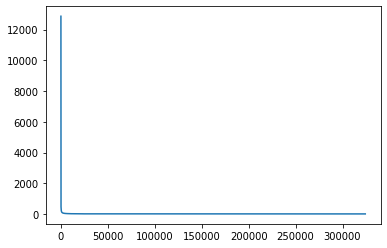

In [11]:
hashtag_cnt_values = sorted(hashtag_cnt, reverse=True)
plt.clf()
plt.plot(hashtag_cnt_values)
plt.show()

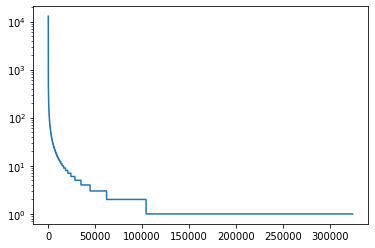

In [12]:
# log scale
plt.clf()
plt.yscale('log')
plt.plot(hashtag_cnt_values)
plt.show()

In [13]:
hashtag_cnt.describe()

count    324268.000000
mean          3.706832
std          34.469729
min           1.000000
25%           1.000000
50%           1.000000
75%           2.000000
max       12873.000000
Name: hashtags_encode, dtype: float64

{'whiskers': [<matplotlib.lines.Line2D at 0x7fc8a7d6b690>,
 'caps': [<matplotlib.lines.Line2D at 0x7fc8a7d6bf10>,
 'boxes': [<matplotlib.lines.Line2D at 0x7fc8a7d6b290>],
 'medians': [<matplotlib.lines.Line2D at 0x7fc8a7d6a810>],
 'fliers': [<matplotlib.lines.Line2D at 0x7fc8a7d6d0d0>],
 'means': [<matplotlib.lines.Line2D at 0x7fc8a7d6ac50>]}

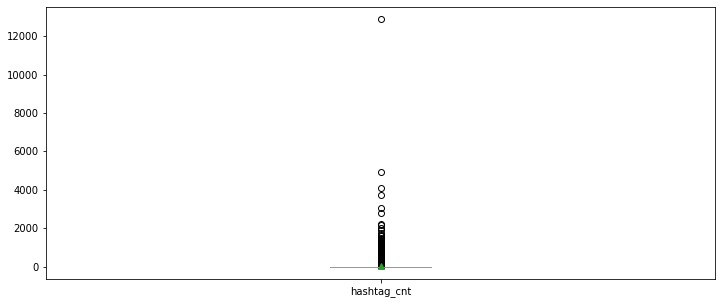

In [14]:
plt.figure(figsize=(12, 5))
plt.boxplot([hashtag_cnt],
             labels=['hashtag_cnt'],
             showmeans=True)

## 2. Recived engagement for tweets with the popular hashtag

In [15]:
top_hashtag_idx = hashtag_cnt[:40].index.values
# top_hashtag_cnt = hashtag_cnt[:40].values

In [16]:
top_hashtag_idx

array([  26,  239,  481,  616,   23,  132,  711,  205,  670, 1767,  206,
        763,   38,  741, 2120,  816,  599,  131, 2118, 1157, 1088, 2052,
        108,  584,  247, 1703, 2752, 2229, 2410,  425, 1625,  459, 1089,
        831, 3566,  186, 2820, 1348, 1519, 1338])

In [17]:
top_hashtag_examples = pd.DataFrame(columns=df.columns)
for i in top_hashtag_idx:
    tmp = df.loc[df['hashtags_encode'] == i].compute()
    top_hashtag_examples = pd.concat([top_hashtag_examples, tmp])
top_hashtag_examples = top_hashtag_examples.reset_index(drop=True)
len(top_hashtag_examples)

75794

In [18]:
top_hashtag_examples.head(10)

,tweet_type,language,hashtags,hashtags_encode,language_encode,is_reply,is_retweet,is_comment,is_like,is_positive,is_negative
0,TopLevel,B8B04128918BBF54E2E178BFF1ABA833,A338C5C1637BEDA847BC1237241145BC,26,5,0,1,0,0,1,0
1,Retweet,B8B04128918BBF54E2E178BFF1ABA833,A338C5C1637BEDA847BC1237241145BC,26,5,0,0,0,0,0,1
2,TopLevel,B8B04128918BBF54E2E178BFF1ABA833,A338C5C1637BEDA847BC1237241145BC,26,5,0,0,0,0,0,1
3,TopLevel,B8B04128918BBF54E2E178BFF1ABA833,A338C5C1637BEDA847BC1237241145BC,26,5,0,0,0,0,0,1
4,TopLevel,41776FB50B812A6775C2F8DEC92A9779,A338C5C1637BEDA847BC1237241145BC,26,25,0,0,0,0,0,1
5,Retweet,B8B04128918BBF54E2E178BFF1ABA833,A338C5C1637BEDA847BC1237241145BC,26,5,0,1,0,0,1,0
6,Retweet,B8B04128918BBF54E2E178BFF1ABA833,A338C5C1637BEDA847BC1237241145BC,26,5,0,0,0,0,0,1
7,TopLevel,B8B04128918BBF54E2E178BFF1ABA833,A338C5C1637BEDA847BC1237241145BC,26,5,0,0,0,1,1,0
8,Retweet,B8B04128918BBF54E2E178BFF1ABA833,A338C5C1637BEDA847BC1237241145BC,26,5,0,0,0,1,1,0
9,TopLevel,B8B04128918BBF54E2E178BFF1ABA833,A338C5C1637BEDA847BC1237241145BC,26,5,0,0,0,1,1,0


- Most hashtags are in the same language.

Positive engagements :  35690
Negative engagements :  40104


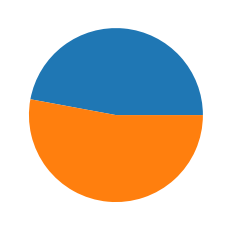

In [19]:
n_positive_engagements = top_hashtag_examples['is_positive'].sum()
n_negative_engagements = top_hashtag_examples['is_negative'].sum()

print('Positive engagements : ', n_positive_engagements)
print('Negative engagements : ', n_negative_engagements)

plt.pie([n_positive_engagements, n_negative_engagements])
plt.show()


Reply engagements :  965
Rtweet engagements :  8384
Comment engagements :  687
Like engagements :  27689


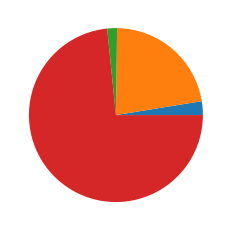

In [20]:
# for positive enagements
n_reply_engagements = top_hashtag_examples['is_reply'].sum()
n_retweet_engagements = top_hashtag_examples['is_retweet'].sum()
n_comment_engagements = top_hashtag_examples['is_comment'].sum()
n_like_engagements = top_hashtag_examples['is_like'].sum()

print('Reply engagements : ', n_reply_engagements)
print('Rtweet engagements : ', n_retweet_engagements)
print('Comment engagements : ', n_comment_engagements)
print('Like engagements : ', n_like_engagements)

plt.pie([n_reply_engagements, n_retweet_engagements, n_comment_engagements, n_like_engagements])
plt.show()

## 3. Let's do the same thing for each language


### engagement count

In [21]:
language_types = sorted(df['language_encode'].compute().value_counts().index.values)
n_languages = len(language_types)

In [22]:
# Declaring some auxiliary structures
n_engagements_arr = np.zeros(n_languages).astype('int32')
n_positive_engagements_arr = np.empty(n_languages).astype('int32')
n_negative_engagements_arr = np.empty(n_languages).astype('int32')
n_like_engagements_arr = np.empty(n_languages).astype('int32')
n_retweet_engagements_arr = np.empty(n_languages).astype('int32')
n_reply_engagements_arr = np.empty(n_languages) .astype('int32')
n_comment_engagements_arr = np.empty(n_languages).astype('int32')

In [23]:
aggregate_result = df.groupby(['language_encode', 'hashtags_encode']).sum().compute()
aggregate_result.head()

is_reply  is_retweet  is_comment  is_like  \
language_encode hashtags_encode                                              
0               0                       0           0           0        0   
                1                       0           0           0        0   
                12                      0           3           0        0   
                33                      0           1           0        0   
                37                      0           1           0        1   

                                 is_positive  is_negative  
language_encode hashtags_encode                            
0               0                          0            2  
                1                          0            3  
                12                         3            2  
                33                         1            1  
                37                         2            2

### Hashtag count

In [24]:
aggregate_result = df.groupby(['language_encode', 'hashtags_encode']).count()
# aggregate_result = aggregate_result.reset_index(['language_encode', 'hashtags_encode'])
aggregate_result = aggregate_result[["hashtags"]]
aggregate_result['cnt'] = aggregate_result['hashtags']
aggregate_result = aggregate_result.drop('hashtags', axis=1)

In [25]:
aggregate_result = aggregate_result.reset_index()

In [26]:
aggregate_result.head()

,language_encode,hashtags_encode,cnt
0,0,0,2
1,0,1,3
2,0,12,5
3,0,33,2
4,0,37,4


In [27]:
len(aggregate_result)

386311

In [28]:
top_n = 40
language_hashtags = [[] for _ in range(n_languages)]
for i in range(n_languages):
    try:
        tmp = aggregate_result.loc[aggregate_result['language_encode'] == i]
        tmp = tmp.compute().sort_values('cnt', ascending=False)[:top_n]
        # tmp = sorted(aggregate_result.loc[aggregate_result['language_encode'] == 0]['cnt'], reverse=True)[:30]
        # tmp = tmp[['cnt']].sort_values("cnt", ascending=False)

        language_hashtags[i] = tmp
    except:
        pass

In [29]:
language_hashtags[0].head()

,language_encode,hashtags_encode,cnt
128,0,1625,705
355,0,5962,522
61,0,774,505
54,0,736,473
59,0,741,419


In [30]:
language_hashtags[4]['cnt']

31708    456
31701    294
31838    235
31699    194
31680    166
31737    145
31739    126
31837    118
31839    114
31960    111
31836    105
31679    103
31810     97
31729     95
31827     92
32053     92
32052     90
31786     84
31823     81
31811     79
31847     75
31899     75
31991     75
31782     71
31964     70
31724     70
31689     69
32029     69
32017     68
32177     67
31930     67
31738     66
31959     65
31794     65
31702     64
31808     63
31730     62
31767     62
31919     52
31818     52
Name: cnt, dtype: int64

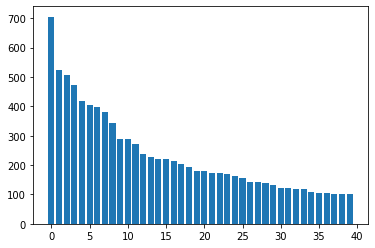

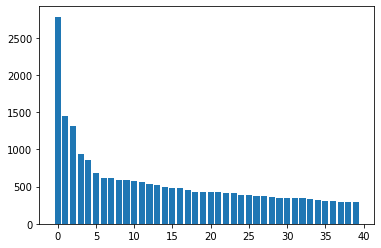

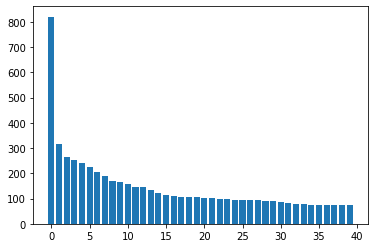

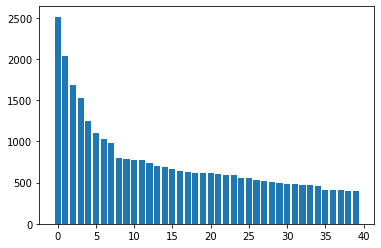

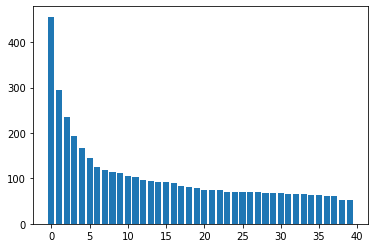

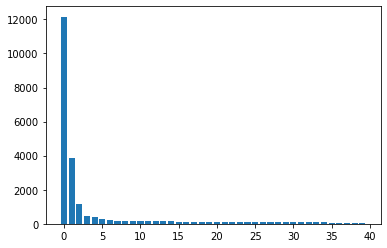

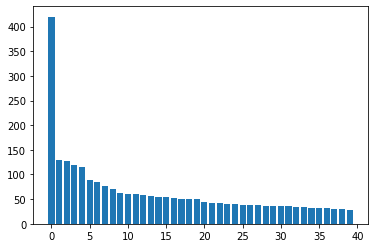

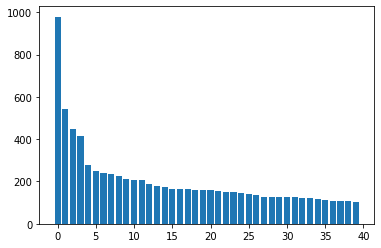

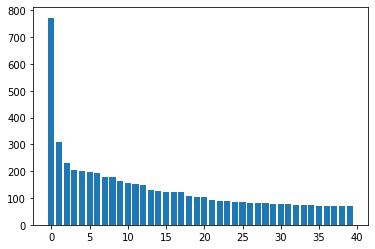

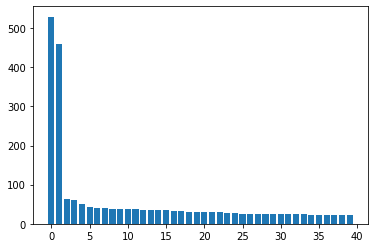

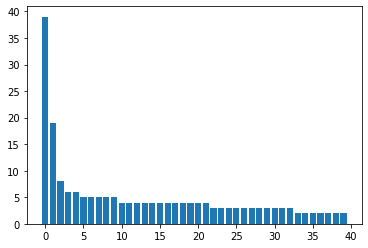

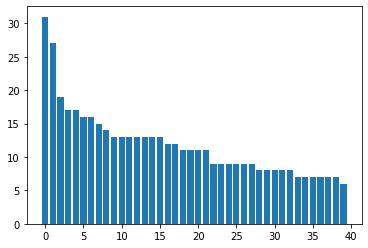

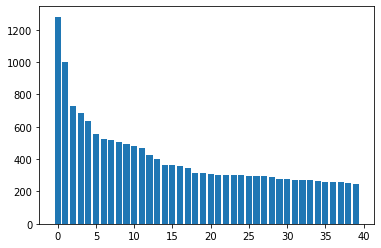

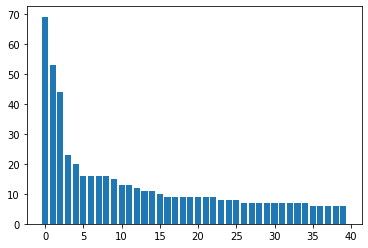

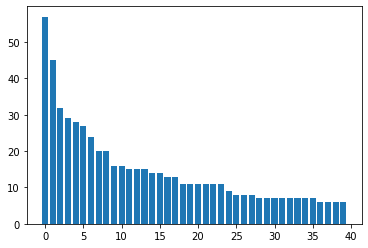

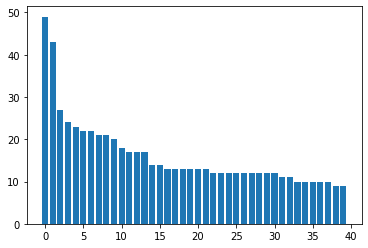

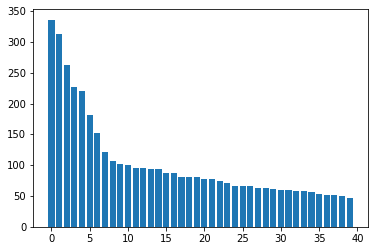

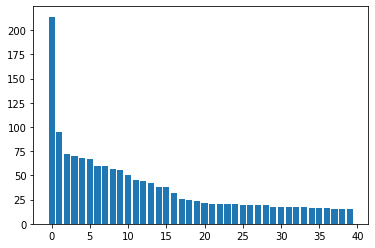

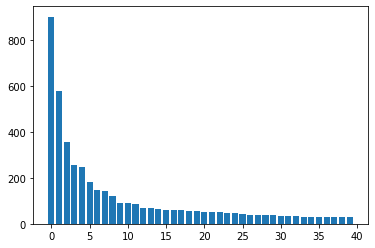

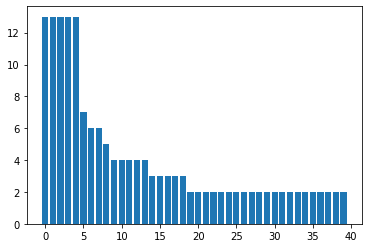

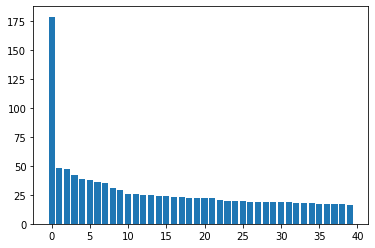

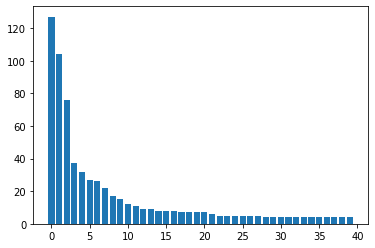

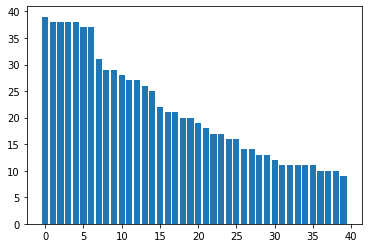

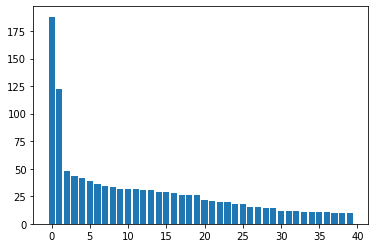

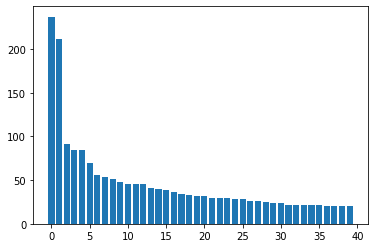

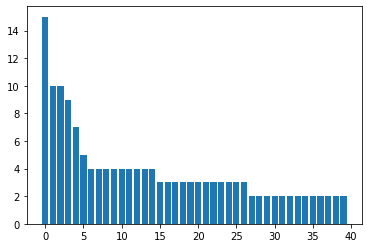

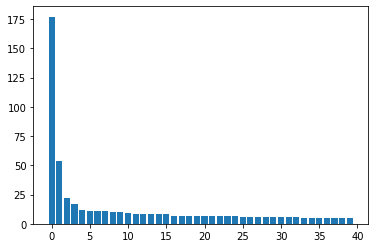

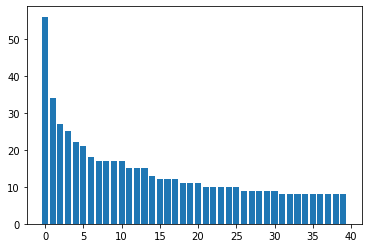

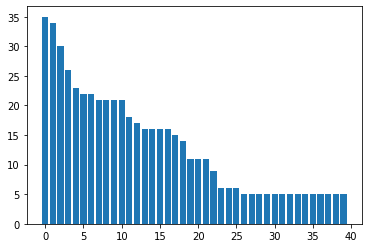

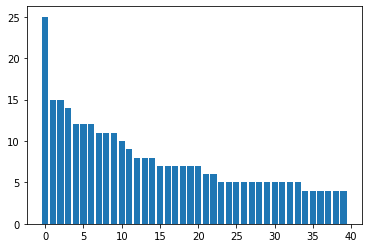

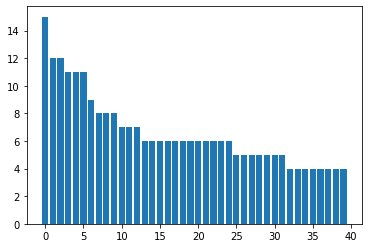

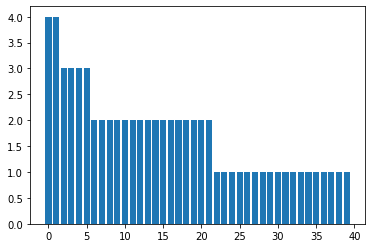

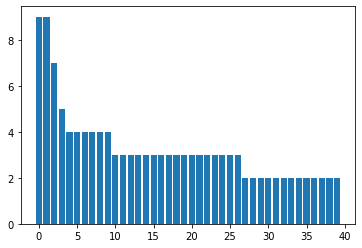

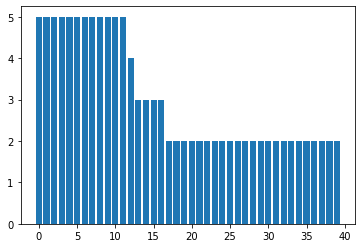

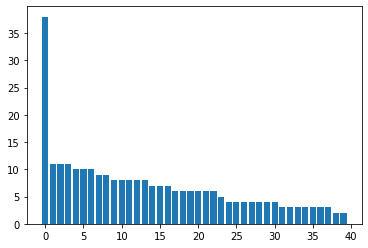

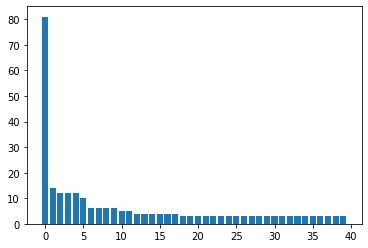

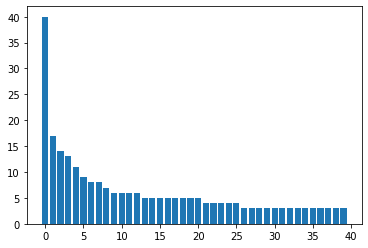

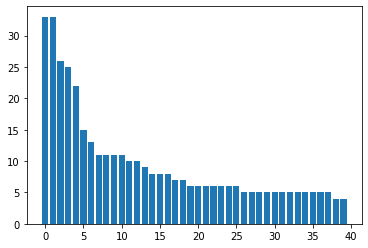

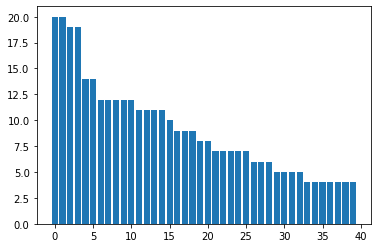

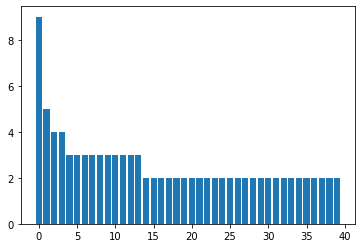

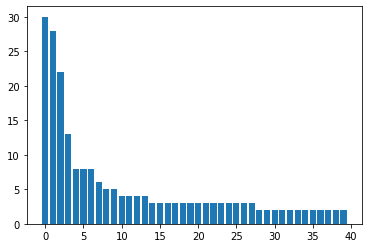

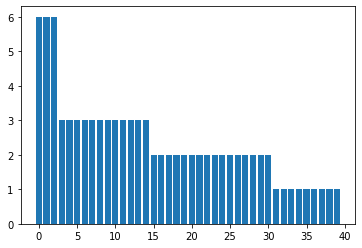

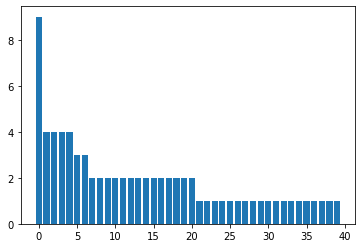

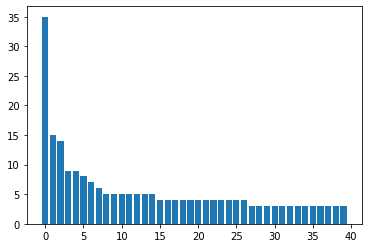

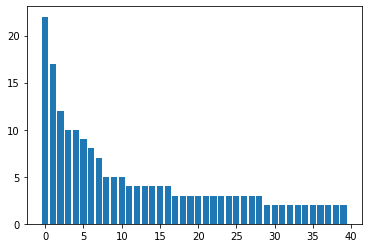

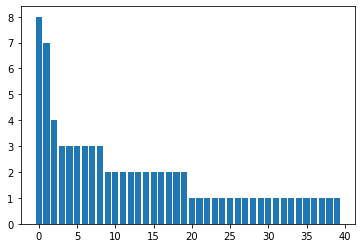

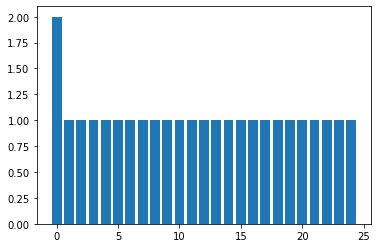

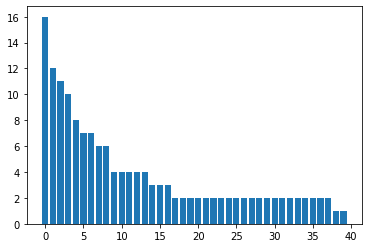

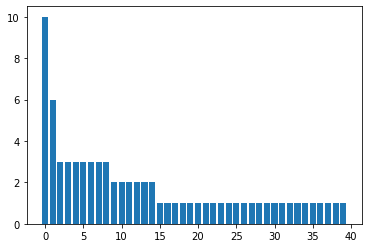

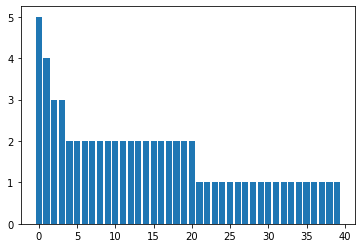

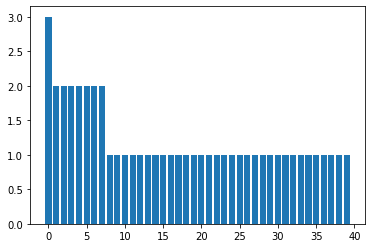

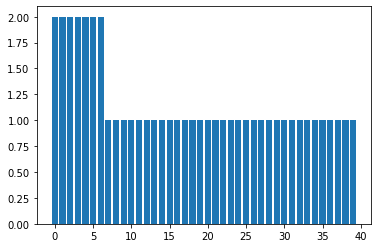

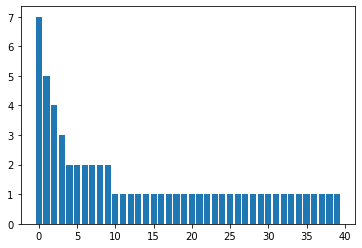

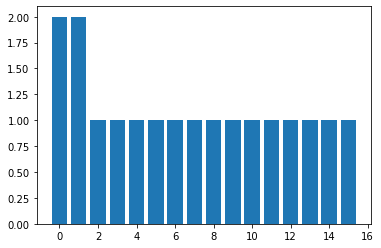

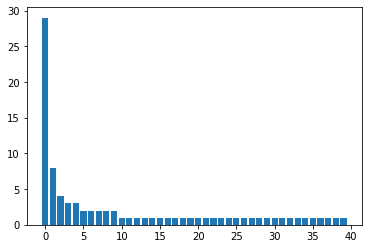

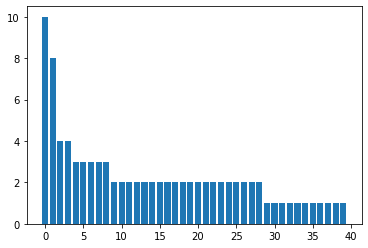

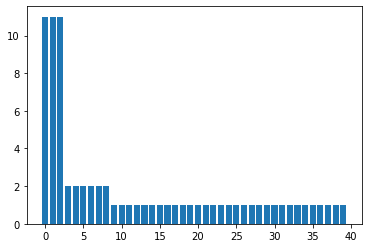

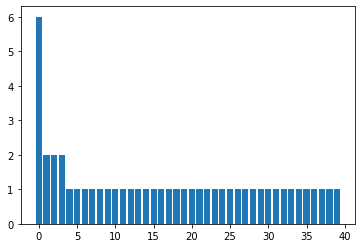

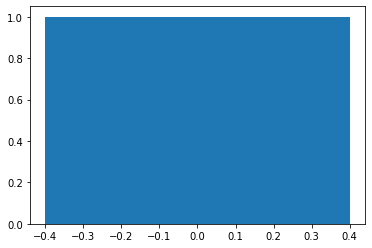

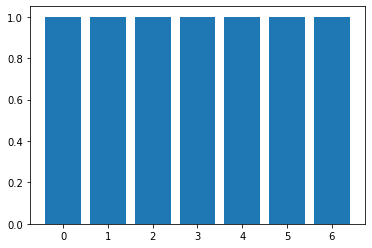

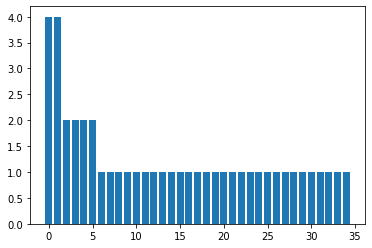

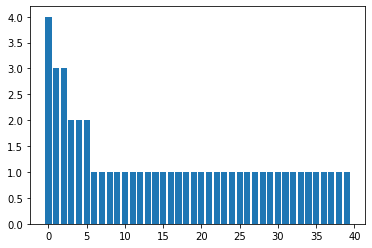

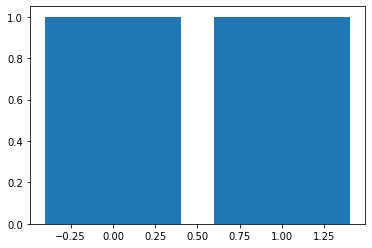

In [31]:
for i in range(n_languages):
    plt.bar(range(len(language_hashtags[i])), language_hashtags[i]['cnt'])
    plt.show()

In [32]:
for i in range(n_languages):
    max_cnt = language_hashtags[i]['cnt'].max()
    print(f"Language {i} - max tag count: {int(max_cnt):n} ")

Language 0 - max tag count: 705 
Language 1 - max tag count: 2783 
Language 2 - max tag count: 820 
Language 3 - max tag count: 2514 
Language 4 - max tag count: 456 
Language 5 - max tag count: 12156 
Language 6 - max tag count: 420 
Language 7 - max tag count: 979 
Language 8 - max tag count: 772 
Language 9 - max tag count: 529 
Language 10 - max tag count: 39 
Language 11 - max tag count: 31 
Language 12 - max tag count: 1281 
Language 13 - max tag count: 69 
Language 14 - max tag count: 57 
Language 15 - max tag count: 49 
Language 16 - max tag count: 336 
Language 17 - max tag count: 214 
Language 18 - max tag count: 902 
Language 19 - max tag count: 13 
Language 20 - max tag count: 179 
Language 21 - max tag count: 127 
Language 22 - max tag count: 39 
Language 23 - max tag count: 188 
Language 24 - max tag count: 237 
Language 25 - max tag count: 15 
Language 26 - max tag count: 177 
Language 27 - max tag count: 56 
Language 28 - max tag count: 35 
Language 29 - max tag count: 